# Lambda School Data Science - Ridge Regression

Regularize your way to a better tomorrow.

# Lecture

Data science depends on math, and math is generally focused on situations where:

1. a solution exists,
2. the solution is unique,
3. the solution's behavior changes continuously with the initial conditions.

These are known as [well-posed problems](https://en.wikipedia.org/wiki/Well-posed_problem), and are the sorts of assumptions so core in traditional techniques that it is easy to forget about them. But they do matter, as there can be exceptions:

1. no solution - e.g. no $x$ such that $Ax = b$
2. multiple solutions - e.g. several $x_1, x_2, ...$ such that $Ax = b$
3. "chaotic" systems - situations where small changes in initial conditions interact and reverberate in essentially unpredictable ways - for instance, the difficulty in longterm predictions of weather (N.B. not the same thing as longterm predictions of *climate*) - you can think of this as models that fail to generalize well, because they overfit on the training data (the initial conditions)

Problems suffering from the above are called ill-posed problems. Relating to linear algebra and systems of equations, the only truly well-posed problems are those with a single unique solution.

![Intersecting lines](https://upload.wikimedia.org/wikipedia/commons/c/c0/Intersecting_Lines.svg)

Think for a moment - what would the above plot look like if there was no solution? If there were multiple solutions? And how would that generalize to higher dimensions?

A lot of what you covered with linear regression was about getting matrices into the right shape for them to be solvable in this sense. But some matrices just won't submit to this, and other problems may technically "fit" linear regression but still be violating the above assumptions in subtle ways.

[Overfitting](https://en.wikipedia.org/wiki/Overfitting) is in some ways a special case of this - an overfit model uses more features/parameters than is "justified" by the data (essentially by the *dimensionality* of the data, as measured by $n$ the number of observations). As the number of features approaches the number of observations, linear regression still "works", but it starts giving fairly perverse results. In particular, it results in a model that fails to *generalize* - and so the core goal of prediction and explanatory power is undermined.

How is this related to well and ill-posed problems? It's not clearly a no solution or multiple solution case, but it does fall in the third category - overfitting results in fitting to the "noise" in the data, which means the particulars of one random sample or another (different initial conditions )will result in dramatically different models.

## Stop and think - what are ways to address these issues?

Let's examine in the context of housing data.

In [0]:
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.preprocessing import scale

boston = load_boston()
boston.data = scale(boston.data)  # Very helpful for regularization!
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['Price'] = boston.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
0,-0.419782,0.284830,-1.287909,-0.272599,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,0.441052,-1.075562,24.0
1,-0.417339,-0.487722,-0.593381,-0.272599,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303094,0.441052,-0.492439,21.6
2,-0.417342,-0.487722,-0.593381,-0.272599,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,0.396427,-1.208727,34.7
3,-0.416750,-0.487722,-1.306878,-0.272599,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,0.416163,-1.361517,33.4
4,-0.412482,-0.487722,-1.306878,-0.272599,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,0.113032,0.441052,-1.026501,36.2


In [0]:
?scale

In [0]:
df.shape

(506, 14)

In [0]:
# Let's try good old least squares!
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X = df.drop('Price', axis='columns')
y = df.Price

lin_reg = LinearRegression().fit(X, y)
mean_squared_error(y, lin_reg.predict(X))

21.894831181729206

That seems like a pretty good score, but...

![Kitchen Sink](https://i.imgur.com/ZZxqhT1.jpg)

Chances are this doesn't generalize very well. You can verify this by splitting the data to properly test model validity.

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=43)
lin_reg_split = LinearRegression().fit(X_train, y_train)
print(mean_squared_error(y, lin_reg_split.predict(X)))
print(mean_squared_error(y_test, lin_reg_split.predict(X_test)))

22.347018673376052
26.273991426429014


Oops! 💥

### What can we do?

- Use fewer features - sure, but it can be a lot of work to figure out *which* features, and (in cases like this) there may not be any good reason to really favor some features over another.
- Get more data! This is actually a pretty good approach in tech, since apps generate lots of data all the time (and we made this situation by artificially constraining our data). But for case studies, existing data, etc. it won't work.
- **Regularize!**

## Regularization just means "add bias"

OK, there's a bit more to it than that. But that's the core intuition - the problem is the model working "too well", so fix it by making it harder for the model!

It may sound strange - a technique that is purposefully "worse" - but in certain situations, it can really get results.

What's bias? In the context of statistics and machine learning, bias is when a predictive model fails to identify relationships between features and the output. In a word, bias is *underfitting*.

We want to add bias to the model because of the [bias-variance tradeoff](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff) - variance is the sensitivity of a model to the random noise in its training data (i.e. *overfitting*), and bias and variance are naturally (inversely) related. Increasing one will always decrease the other, with regards to the overall generalization error (predictive accuracy on unseen data).

Visually, the result looks like this:

![Regularization example plot](https://upload.wikimedia.org/wikipedia/commons/0/02/Regularization.svg)

The blue line is overfit, using more dimensions than are needed to explain the data and so much of the movement is based on noise and won't generalize well. The green line still fits the data, but is less susceptible to the noise - depending on how exactly we parameterize "noise" we may throw out actual correlation, but if we balance it right we keep that signal and greatly improve generalizability.

### Look carefully at the above plot and think of ways you can quantify the difference between the blue and green lines...


In [0]:
# Now with regularization via ridge regression
from sklearn.linear_model import Ridge

ridge_reg = Ridge().fit(X, y)
mean_squared_error(y, ridge_reg.predict(X))

21.895862166800143

In [0]:
# The score is a bit worse than OLS - but that's expected (we're adding bias)
# Let's try split

ridge_reg_split = Ridge().fit(X_train, y_train)
mean_squared_error(y_test, ridge_reg_split.predict(X_test))

26.192201358877668

In [0]:
# A little better (to same test split w/OLS) - can we improve it further?
# We just went with defaults, but as always there's plenty of parameters
help(Ridge)

Help on class Ridge in module sklearn.linear_model.ridge:

class Ridge(_BaseRidge, sklearn.base.RegressorMixin)
 |  Linear least squares with l2 regularization.
 |  
 |  Minimizes the objective function::
 |  
 |  ||y - Xw||^2_2 + alpha * ||w||^2_2
 |  
 |  This model solves a regression model where the loss function is
 |  the linear least squares function and regularization is given by
 |  the l2-norm. Also known as Ridge Regression or Tikhonov regularization.
 |  This estimator has built-in support for multi-variate regression
 |  (i.e., when y is a 2d-array of shape [n_samples, n_targets]).
 |  
 |  Read more in the :ref:`User Guide <ridge_regression>`.
 |  
 |  Parameters
 |  ----------
 |  alpha : {float, array-like}, shape (n_targets)
 |      Regularization strength; must be a positive float. Regularization
 |      improves the conditioning of the problem and reduces the variance of
 |      the estimates. Larger values specify stronger regularization.
 |      Alpha corresponds t

How to tune alpha? For now, let's loop and try values.

(For longterm/stretch/next week, check out [cross-validation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV).)

In [0]:
alphas = []
mses = []

for alpha in range(0, 200, 1):
  ridge_reg_split = Ridge(alpha=alpha).fit(X_train, y_train)
  mse = mean_squared_error(y_test, ridge_reg_split.predict(X_test))
  print(alpha, mse)
  alphas.append(alpha)
  mses.append(mse)

0 26.273991426429053
1 26.192201358877668
2 26.118328007697226
3 26.051117952293595
4 25.989569283205444
5 25.93287356811407
6 25.880372753122625
7 25.831526788692837
8 25.785889053385123
9 25.743087513207442
10 25.702810145277628
11 25.66479356379559
12 25.628814073392263
13 25.59468057863174
14 25.56222892458644
15 25.53131734932431
16 25.50182280665663
17 25.473637974726547
18 25.44666880864133
19 25.420832527348388
20 25.396055949160893
21 25.372274108781504
22 25.349429102822004
23 25.327469121742823
24 25.30634763462536
25 25.286022699825878
26 25.266456379775086
27 25.24761424230921
28 25.229464934192976
29 25.211979815108453
30 25.19513264248022
31 25.178899299197408
32 25.163257557659424
33 25.14818687468406
34 25.13366821272317
35 25.11968388357409
36 25.106217411385522
37 25.093253412260974
38 25.080777488180427
39 25.068776133307583
40 25.057236651039766
41 25.046147080399017
42 25.035496130566347
43 25.02527312253186
44 25.015467936977434
45 25.006070967630855
46 24.997073

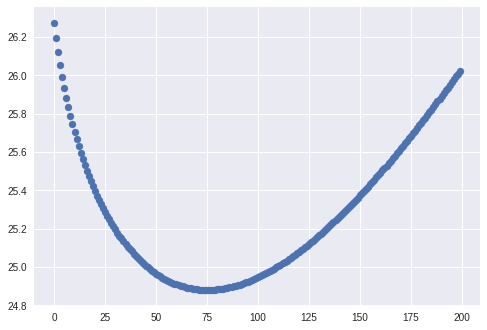

In [0]:
from matplotlib.pyplot import scatter
scatter(alphas, mses);

## What's the intuition? What are we doing?

The `alpha` parameter corresponds to the weight being given to the extra penalty being calculated by [Tikhonov regularization](https://en.wikipedia.org/wiki/Tikhonov_regularization) (this parameter is sometimes referred to as $\lambda$ in the context of ridge regression).

Normal linear regression (OLS) minimizes the **sum of square error of the residuals**.

Ridge regression minimizes the **sum of square error of the residuals** *AND* **the squared slope of the fit model, times the alpha parameter**.

This is why the MSE for the first model in the for loop (`alpha=0`) is the same as the MSE for linear regression - it's the same model!

As `alpha` is increased, we give more and more penalty to a steep slope. In two or three dimensions this is fairly easy to visualize - beyond, think of it as penalizing coefficient size. Each coefficient represents the slope of an individual dimension (feature) of the model, so ridge regression is just squaring and summing those.

So while `alpha=0` reduces to OLS, as `alpha` approaches infinity eventually the penalty gets so extreme that the model will always output every coefficient as 0 (any non-zero coefficient resulting in a penalty that outweighs whatever improvement in the residuals), and just fit a flat model with intercept at the mean of the dependent variable.

Of course, what we want is somewhere in-between these extremes. Intuitively, what we want to do is apply an appropriate "cost" or penalty to the model for fitting parameters, much like adjusted $R^2$ takes into account the cost of adding complexity to a model. What exactly is an appropriate penalty will vary, so you'll have to put on your model comparison hat and give it a go!

PS - scaling the data helps, as that way this cost is consistent and can be added uniformly across features, and it is simpler to search for the `alpha` parameter.

### Bonus - magic! ✨

Ridge regression doesn't just reduce overfitting and help with the third aspect of well-posed problems (poor generalizability). It can also fix the first two (no unique solution)!

In [0]:
df_tiny = df.sample(10, random_state=27)
print(df_tiny.shape)
X = df_tiny.drop('Price', axis='columns')
y = df_tiny.Price

lin_reg = LinearRegression().fit(X, y)
lin_reg.score(X, y)  # Perfect multi-collinearity!
# NOTE - True OLS would 💥 here
# scikit protects us from actual error, but still gives a poor model

(10, 14)


1.0

In [0]:
ridge_reg = Ridge().fit(X, y)
ridge_reg.score(X, y)  # More plausible (not "perfect")

0.9760119331942763

In [0]:
# Using our earlier test split
mean_squared_error(y_test, lin_reg.predict(X_test))

103.04429449784261

In [0]:
# Ridge generalizes *way* better (and we've not even tuned alpha)
mean_squared_error(y_test, ridge_reg.predict(X_test))

41.79869373639458

In [0]:
# e.g. (x1^2 + x2^2 + ...) * alpha is the extra penalty from Ridge

## And a bit more math

The regularization used by Ridge Regression is also known as **$L^2$ regularization**, due to the squaring of the slopes being summed. This corresponds to [$L^2$ space](https://en.wikipedia.org/wiki/Square-integrable_function), a metric space of square-integrable functions that generally measure what we intuitively think of as "distance" (at least, on a plane) - what is referred to as Euclidean distance.

The other famous norm is $L^1$, also known as [taxicab geometry](https://en.wikipedia.org/wiki/Taxicab_geometry), because it follows the "grid" to measure distance like a car driving around city blocks (rather than going directly like $L^2$). When referred to as a distance this is called "Manhattan distance", and can be used for regularization (see [LASSO](https://en.wikipedia.org/wiki/Lasso_(statistics%29), which [uses the $L^1$ norm](https://www.quora.com/What-is-the-difference-between-L1-and-L2-regularization-How-does-it-solve-the-problem-of-overfitting-Which-regularizer-to-use-and-when)).

All this comes down to - regularization means increasing model bias by "watering down" coefficients with a penalty typically based on some sort of distance metric, and thus reducing variance (overfitting the model to the noise in the data). It gives us another lever to try and another tool for our toolchest!

## Putting it all together - one last example

The official scikit-learn documentation has many excellent examples - [this one](https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols_ridge_variance.html#sphx-glr-auto-examples-linear-model-plot-ols-ridge-variance-py) illustrates how ridge regression effectively reduces the variance, again by increasing the bias, penalizing coefficients to reduce the effectiveness of features (but also the impact of noise).

```
Due to the few points in each dimension and the straight line that linear regression uses to follow these points as well as it can, noise on the observations will cause great variance as shown in the first plot. Every line’s slope can vary quite a bit for each prediction due to the noise induced in the observations.

Ridge regression is basically minimizing a penalised version of the least-squared function. The penalising shrinks the value of the regression coefficients. Despite the few data points in each dimension, the slope of the prediction is much more stable and the variance in the line itself is greatly reduced, in comparison to that of the standard linear regression
```

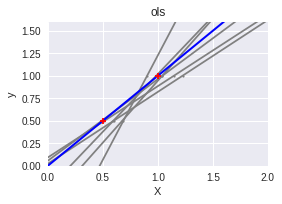

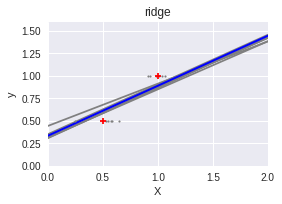

In [0]:
# Code source: Gaël Varoquaux
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause


import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model

X_train = np.c_[.5, 1].T
y_train = [.5, 1]
X_test = np.c_[0, 2].T

np.random.seed(0)

classifiers = dict(ols=linear_model.LinearRegression(),
                   ridge=linear_model.Ridge(alpha=.1))

for name, clf in classifiers.items():
    fig, ax = plt.subplots(figsize=(4, 3))

    for _ in range(6):
        this_X = .1 * np.random.normal(size=(2, 1)) + X_train
        clf.fit(this_X, y_train)

        ax.plot(X_test, clf.predict(X_test), color='gray')
        ax.scatter(this_X, y_train, s=3, c='gray', marker='o', zorder=10)

    clf.fit(X_train, y_train)
    ax.plot(X_test, clf.predict(X_test), linewidth=2, color='blue')
    ax.scatter(X_train, y_train, s=30, c='red', marker='+', zorder=10)

    ax.set_title(name)
    ax.set_xlim(0, 2)
    ax.set_ylim((0, 1.6))
    ax.set_xlabel('X')
    ax.set_ylabel('y')

    fig.tight_layout()

plt.show()

# Assignment

Following is data describing characteristics of blog posts, with a target feature of how many comments will be posted in the following 24 hours.

https://archive.ics.uci.edu/ml/datasets/BlogFeedback

Investigate - you can try both linear and ridge. You can also sample to smaller data size and see if that makes ridge more important. Don't forget to scale!

Focus on the training data, but if you want to load and compare to any of the test data files you can also do that.

Note - Ridge may not be that fundamentally superior in this case. That's OK! It's still good to practice both, and see if you can find parameters or sample sizes where ridge does generalize and perform better.

When you've fit models to your satisfaction, answer the following question:

```
Did you find cases where Ridge performed better? If so, describe (alpha parameter, sample size, any other relevant info/processing). If not, what do you think that tells you about the data?
```

You can create whatever plots, tables, or other results support your argument. In this case, your target audience is a fellow data scientist, *not* a layperson, so feel free to dig in!

### lets load the data

In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00304/BlogFeedback.zip
!unzip BlogFeedback.zip

--2019-01-24 14:04:07--  https://archive.ics.uci.edu/ml/machine-learning-databases/00304/BlogFeedback.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.249
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2583605 (2.5M) [application/zip]
Saving to: ‘BlogFeedback.zip’

BlogFeedback.zip    100%[===================>]   2.46M  5.84MB/s    in 0.4s    

2019-01-24 14:04:08 (5.84 MB/s) - ‘BlogFeedback.zip’ saved [2583605/2583605]

Archive:  BlogFeedback.zip
  inflating: blogData_test-2012.02.01.00_00.csv  
  inflating: blogData_test-2012.02.02.00_00.csv  
  inflating: blogData_test-2012.02.03.00_00.csv  
  inflating: blogData_test-2012.02.04.00_00.csv  
  inflating: blogData_test-2012.02.05.00_00.csv  
  inflating: blogData_test-2012.02.06.00_00.csv  
  inflating: blogData_test-2012.02.07.00_00.csv  
  inflating: blogData_test-2012.02.08.00_00.csv  
  inflating: blogData_test-20

In [10]:
#import all the modules 
from __future__ import print_function, division
import pandas as pd

from __future__ import print_function, division
import numpy as np
import scipy as sp

from sklearn.preprocessing import scale


In [6]:
df = pd.read_csv('blogData_train.csv', header= None)

In [7]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,271,272,273,274,275,276,277,278,279,280
0,40.30467,53.845657,0.0,401.0,15.0,15.52416,32.44188,0.0,377.0,3.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,40.30467,53.845657,0.0,401.0,15.0,15.52416,32.44188,0.0,377.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,40.30467,53.845657,0.0,401.0,15.0,15.52416,32.44188,0.0,377.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,40.30467,53.845657,0.0,401.0,15.0,15.52416,32.44188,0.0,377.0,3.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,40.30467,53.845657,0.0,401.0,15.0,15.52416,32.44188,0.0,377.0,3.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0


In [8]:
df.shape

(52397, 281)

In [9]:
df.isna().sum()

0      0
1      0
2      0
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     0
18     0
19     0
20     0
21     0
22     0
23     0
24     0
25     0
26     0
27     0
28     0
29     0
      ..
251    0
252    0
253    0
254    0
255    0
256    0
257    0
258    0
259    0
260    0
261    0
262    0
263    0
264    0
265    0
266    0
267    0
268    0
269    0
270    0
271    0
272    0
273    0
274    0
275    0
276    0
277    0
278    0
279    0
280    0
Length: 281, dtype: int64

In [14]:
#the file doesn't seem to have midding values
#then let's import the scaler
from sklearn.preprocessing import scale
scaled_df = scale(df)
scaled_df = pd.DataFrame(scaled_df)


In [16]:
pd.set_option('display.max_columns', None)
scaled_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280
0,0.010876,0.112877,-0.052468,0.138521,-0.139108,0.009598,0.116182,-0.020836,0.368246,-0.119031,-0.00031,0.113595,0.0,0.374998,-0.11243,-0.004944,0.129936,-0.052468,0.245038,-0.161788,0.080132,0.119797,-0.480089,0.390503,0.140192,0.598229,1.06407,-0.029263,0.781584,-0.324229,0.581057,0.931022,0.0,0.8758,-0.140659,0.578108,0.92603,0.0,0.876995,-0.022591,0.573526,1.073282,-0.029263,0.763658,-0.249724,0.499465,0.885857,-0.898355,0.910838,-0.015447,-0.337079,-0.229670,-0.249138,-0.346756,0.012103,-0.320777,-0.21839,-0.206545,-0.310545,-0.010048,-1.199772,-0.747296,-0.040546,-0.461678,-0.008738,-0.017477,-0.739905,-0.432851,-0.564119,-0.049292,-0.058549,-0.190451,-0.008738,-0.025482,-0.069517,-0.008738,-0.128719,-0.037607,-0.536624,-0.008738,-0.008738,-0.057888,-0.039591,-0.013816,-0.017477,-0.14596,-0.013816,-0.108441,-0.259927,-0.011559,-0.017477,-0.015753,-0.06924,-0.008738,-0.013816,-0.313762,-0.008738,-0.020495,-0.019046,-0.033289,-1.226344,-0.287567,-0.176444,-0.229929,-0.055344,-0.035782,-0.05447,-0.128028,-0.011559,-0.160884,-0.013816,-0.020495,-0.017477,-0.419249,-0.268361,-0.145755,-0.040782,-0.111464,-0.231901,-0.440503,-0.198537,-0.554032,-0.020956,-0.011559,-0.102996,-0.021848,-0.079002,-0.123168,-0.011559,-0.008738,-0.070618,-0.008738,-0.024331,-0.205193,-0.167503,-0.222754,-0.062978,-0.17477,-0.581809,-0.288615,-0.284011,-0.049679,-1.36741,-0.088478,-0.060961,-0.055517,-0.071432,-0.015753,-0.008738,-0.047711,-0.605361,-0.045658,-0.22762,-0.182952,-0.011559,-0.008738,-0.092655,-0.708757,-0.354479,-0.034971,-0.008738,-0.173081,-0.1669,-0.075118,-0.036313,-0.008738,-0.035782,-0.016348,-0.008738,-0.441769,-0.02899,-0.008738,-0.017477,-0.131525,-0.054821,-0.034971,-0.062978,-0.020495,-0.008738,-0.322745,-0.210391,-0.099729,-0.28846,-0.341206,-0.019046,-0.126791,-0.149668,-0.075885,-0.122367,-0.008738,-0.349066,-0.128873,-0.386666,-0.421449,-0.14459,-0.13115,-0.289468,-0.008738,-0.017477,-0.008738,-0.061589,-0.452126,-0.02899,-0.042394,-0.102712,-0.064488,-0.232631,-0.110406,-0.035782,-0.600006,-0.051013,-0.008738,-0.936565,-0.022281,-0.064488,-0.261138,-0.024331,-0.047104,-0.168224,-0.047711,-0.210044,-0.037861,-0.011559,-0.017477,-0.080936,-0.747271,-0.079733,-0.396779,-0.039591,-0.364666,-0.065377,-0.801457,-0.431047,-0.209052,-0.037352,-0.008738,-0.07356,-0.049292,-0.030595,-0.042619,-0.167443,-0.121156,-0.008738,-0.011559,-0.144728,-1.328428,-0.375136,-0.526081,-0.088149,-0.008738,-0.123884,-0.080216,-0.013816,-0.16324,-0.122045,-0.015753,-0.209499,-0.047911,-0.058712,-0.051201,-0.092341,-0.017477,-0.358559,-0.361906,-0.400283,-0.445005,2.227325,-0.439113,-0.399224,-0.43518,-0.448846,-0.454696,2.272362,-0.427399,-0.326158,-0.312402,-0.08286,0.0,-0.045171,-0.037836,-0.152885
1,0.010876,0.112877,-0.052468,0.138521,-0.139108,0.009598,0.116182,-0.020836,0.368246,-0.119031,-0.00031,0.113595,0.0,0.374998,-0.11243,-0.004944,0.129936,-0.052468,0.245038,-0.161788,0.080132,0.119797,-0.480089,0.390503,0.140192,0.598229,1.06407,-0.029

In [27]:
#let's rename the last column for now
#last column is our y
#if you dont assign it to the df, it doesn't work
scaled_df = scaled_df.rename(columns={ scaled_df.columns[-1]: "target" })

In [32]:
scaled_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,target
0,0.010876,0.112877,-0.052468,0.138521,-0.139108,0.009598,0.116182,-0.020836,0.368246,-0.119031,-0.00031,0.113595,0.0,0.374998,-0.11243,-0.004944,0.129936,-0.052468,0.245038,-0.161788,0.080132,0.119797,-0.480089,0.390503,0.140192,0.598229,1.06407,-0.029263,0.781584,-0.324229,0.581057,0.931022,0.0,0.8758,-0.140659,0.578108,0.92603,0.0,0.876995,-0.022591,0.573526,1.073282,-0.029263,0.763658,-0.249724,0.499465,0.885857,-0.898355,0.910838,-0.015447,-0.337079,-0.229670,-0.249138,-0.346756,0.012103,-0.320777,-0.21839,-0.206545,-0.310545,-0.010048,-1.199772,-0.747296,-0.040546,-0.461678,-0.008738,-0.017477,-0.739905,-0.432851,-0.564119,-0.049292,-0.058549,-0.190451,-0.008738,-0.025482,-0.069517,-0.008738,-0.128719,-0.037607,-0.536624,-0.008738,-0.008738,-0.057888,-0.039591,-0.013816,-0.017477,-0.14596,-0.013816,-0.108441,-0.259927,-0.011559,-0.017477,-0.015753,-0.06924,-0.008738,-0.013816,-0.313762,-0.008738,-0.020495,-0.019046,-0.033289,-1.226344,-0.287567,-0.176444,-0.229929,-0.055344,-0.035782,-0.05447,-0.128028,-0.011559,-0.160884,-0.013816,-0.020495,-0.017477,-0.419249,-0.268361,-0.145755,-0.040782,-0.111464,-0.231901,-0.440503,-0.198537,-0.554032,-0.020956,-0.011559,-0.102996,-0.021848,-0.079002,-0.123168,-0.011559,-0.008738,-0.070618,-0.008738,-0.024331,-0.205193,-0.167503,-0.222754,-0.062978,-0.17477,-0.581809,-0.288615,-0.284011,-0.049679,-1.36741,-0.088478,-0.060961,-0.055517,-0.071432,-0.015753,-0.008738,-0.047711,-0.605361,-0.045658,-0.22762,-0.182952,-0.011559,-0.008738,-0.092655,-0.708757,-0.354479,-0.034971,-0.008738,-0.173081,-0.1669,-0.075118,-0.036313,-0.008738,-0.035782,-0.016348,-0.008738,-0.441769,-0.02899,-0.008738,-0.017477,-0.131525,-0.054821,-0.034971,-0.062978,-0.020495,-0.008738,-0.322745,-0.210391,-0.099729,-0.28846,-0.341206,-0.019046,-0.126791,-0.149668,-0.075885,-0.122367,-0.008738,-0.349066,-0.128873,-0.386666,-0.421449,-0.14459,-0.13115,-0.289468,-0.008738,-0.017477,-0.008738,-0.061589,-0.452126,-0.02899,-0.042394,-0.102712,-0.064488,-0.232631,-0.110406,-0.035782,-0.600006,-0.051013,-0.008738,-0.936565,-0.022281,-0.064488,-0.261138,-0.024331,-0.047104,-0.168224,-0.047711,-0.210044,-0.037861,-0.011559,-0.017477,-0.080936,-0.747271,-0.079733,-0.396779,-0.039591,-0.364666,-0.065377,-0.801457,-0.431047,-0.209052,-0.037352,-0.008738,-0.07356,-0.049292,-0.030595,-0.042619,-0.167443,-0.121156,-0.008738,-0.011559,-0.144728,-1.328428,-0.375136,-0.526081,-0.088149,-0.008738,-0.123884,-0.080216,-0.013816,-0.16324,-0.122045,-0.015753,-0.209499,-0.047911,-0.058712,-0.051201,-0.092341,-0.017477,-0.358559,-0.361906,-0.400283,-0.445005,2.227325,-0.439113,-0.399224,-0.43518,-0.448846,-0.454696,2.272362,-0.427399,-0.326158,-0.312402,-0.08286,0.0,-0.045171,-0.037836,-0.152885
1,0.010876,0.112877,-0.052468,0.138521,-0.139108,0.009598,0.116182,-0.020836,0.368246,-0.119031,-0.00031,0.113595,0.0,0.374998,-0.11243,-0.004944,0.129936,-0.052468,0.245038,-0.161788,0.080132,0.119797,-0.480089,0.390503,0.140192,0.598229,1.06407,-0.

In [34]:
#let's run linear regression first
#without splitting it onto train and test
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X = scaled_df.drop('target', axis = 'columns')
y = scaled_df.target

lin_reg = LinearRegression().fit(X, y)
mean_squared_error(y, lin_reg.predict(X))

0.6352503642021322

In [36]:
# now let'split the dataset into train and test
#still linear regression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .5, random_state=42)
lin_reg_split = LinearRegression().fit(X_train, y_train)
print(mean_squared_error(y, lin_reg_split.predict(X)))
print(mean_squared_error(y_test, lin_reg_split.predict(X_test)))

0.6404225626940292
0.6420165902391852


In [ ]:
#Wahoo almost NO difference! Hmm


## let's try Ridge regression

In [37]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge().fit(X, y)
mean_squared_error(y, ridge_reg.predict(X))

0.6353281323627131

In [ ]:
#Exact same! because alpha parameter is zero in this case

In [38]:
#let's try ridge on our split data
ridge_reg_split = Ridge().fit(X_train, y_train)
mean_squared_error(y_test, ridge_reg_split.predict(X_test))

0.6413008411997477

In [ ]:
#Very slight imporvement here

In [46]:
#let's talk about alpha
alphas = []
mses = []

for alpha in range(0, 100, 1):
  ridge_reg_split = Ridge(alpha=alpha).fit(X_train, y_train)
  mse = mean_squared_error(y_test, ridge_reg_split.predict(X_test))
  print(alpha, mse)
  alphas.append(alpha)
  mses.append(mse)

0 0.6546509406824808
1 0.6413008411997477
2 0.6412031522236648
3 0.6411353308084814
4 0.6410849084108126
5 0.6410454965616617
6 0.6410135371156148
7 0.640986887032952
8 0.6409641726672476
9 0.6409444689061441
10 0.6409271273320726
11 0.6409116783039116
12 0.640897772220508
13 0.6408851427392174
14 0.6408735828870312
15 0.6408629290513218
16 0.6408530499552466
17 0.6408438388825527
18 0.6408352080772416
19 0.640827084633347
20 0.6408194074272181
21 0.6408121247929692
22 0.6408051927367683
23 0.6407985735478802
24 0.6407922347059737
25 0.6407861480125184
26 0.6407802888936989
27 0.6407746358360381
28 0.6407691699257492
29 0.6407638744699172
30 0.6407587346828011
31 0.6407537374243809
32 0.6407488709811282
33 0.6407441248811543
34 0.6407394897375187
35 0.6407349571147629
36 0.6407305194146994
37 0.6407261697782539
38 0.6407219020007686
39 0.6407177104586328
40 0.6407135900455062
41 0.6407095361166836
42 0.640705544440413
43 0.6407016111551662
44 0.6406977327320247
45 0.6406939059414822
46

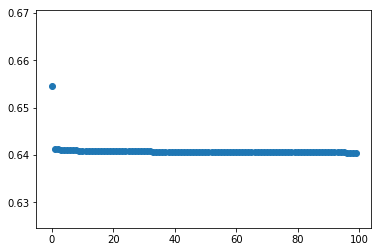

In [49]:
from matplotlib.pyplot import scatter
import matplotlib.pyplot as plt
scatter(alphas, mses);



In [ ]:
#let's make a smaller dataframe with only 100 rows

In [55]:
small_df = scaled_df.loc[0:101,]

In [56]:
small_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,target
0,0.010876,0.112877,-0.052468,0.138521,-0.139108,0.009598,0.116182,-0.020836,0.368246,-0.119031,-0.00031,0.113595,0.0,0.374998,-0.11243,-0.004944,0.129936,-0.052468,0.245038,-0.161788,0.080132,0.119797,-0.480089,0.390503,0.140192,0.598229,1.06407,-0.029263,0.781584,-0.324229,0.581057,0.931022,0.0,0.8758,-0.140659,0.578108,0.92603,0.0,0.876995,-0.022591,0.573526,1.073282,-0.029263,0.763658,-0.249724,0.499465,0.885857,-0.898355,0.910838,-0.015447,-0.337079,-0.229670,-0.249138,-0.346756,0.012103,-0.320777,-0.21839,-0.206545,-0.310545,-0.010048,-1.199772,-0.747296,-0.040546,-0.461678,-0.008738,-0.017477,-0.739905,-0.432851,-0.564119,-0.049292,-0.058549,-0.190451,-0.008738,-0.025482,-0.069517,-0.008738,-0.128719,-0.037607,-0.536624,-0.008738,-0.008738,-0.057888,-0.039591,-0.013816,-0.017477,-0.14596,-0.013816,-0.108441,-0.259927,-0.011559,-0.017477,-0.015753,-0.06924,-0.008738,-0.013816,-0.313762,-0.008738,-0.020495,-0.019046,-0.033289,-1.226344,-0.287567,-0.176444,-0.229929,-0.055344,-0.035782,-0.05447,-0.128028,-0.011559,-0.160884,-0.013816,-0.020495,-0.017477,-0.419249,-0.268361,-0.145755,-0.040782,-0.111464,-0.231901,-0.440503,-0.198537,-0.554032,-0.020956,-0.011559,-0.102996,-0.021848,-0.079002,-0.123168,-0.011559,-0.008738,-0.070618,-0.008738,-0.024331,-0.205193,-0.167503,-0.222754,-0.062978,-0.17477,-0.581809,-0.288615,-0.284011,-0.049679,-1.36741,-0.088478,-0.060961,-0.055517,-0.071432,-0.015753,-0.008738,-0.047711,-0.605361,-0.045658,-0.22762,-0.182952,-0.011559,-0.008738,-0.092655,-0.708757,-0.354479,-0.034971,-0.008738,-0.173081,-0.1669,-0.075118,-0.036313,-0.008738,-0.035782,-0.016348,-0.008738,-0.441769,-0.02899,-0.008738,-0.017477,-0.131525,-0.054821,-0.034971,-0.062978,-0.020495,-0.008738,-0.322745,-0.210391,-0.099729,-0.28846,-0.341206,-0.019046,-0.126791,-0.149668,-0.075885,-0.122367,-0.008738,-0.349066,-0.128873,-0.386666,-0.421449,-0.14459,-0.13115,-0.289468,-0.008738,-0.017477,-0.008738,-0.061589,-0.452126,-0.02899,-0.042394,-0.102712,-0.064488,-0.232631,-0.110406,-0.035782,-0.600006,-0.051013,-0.008738,-0.936565,-0.022281,-0.064488,-0.261138,-0.024331,-0.047104,-0.168224,-0.047711,-0.210044,-0.037861,-0.011559,-0.017477,-0.080936,-0.747271,-0.079733,-0.396779,-0.039591,-0.364666,-0.065377,-0.801457,-0.431047,-0.209052,-0.037352,-0.008738,-0.07356,-0.049292,-0.030595,-0.042619,-0.167443,-0.121156,-0.008738,-0.011559,-0.144728,-1.328428,-0.375136,-0.526081,-0.088149,-0.008738,-0.123884,-0.080216,-0.013816,-0.16324,-0.122045,-0.015753,-0.209499,-0.047911,-0.058712,-0.051201,-0.092341,-0.017477,-0.358559,-0.361906,-0.400283,-0.445005,2.227325,-0.439113,-0.399224,-0.43518,-0.448846,-0.454696,2.272362,-0.427399,-0.326158,-0.312402,-0.08286,0.0,-0.045171,-0.037836,-0.152885
1,0.010876,0.112877,-0.052468,0.138521,-0.139108,0.009598,0.116182,-0.020836,0.368246,-0.119031,-0.00031,0.113595,0.0,0.374998,-0.11243,-0.004944,0.129936,-0.052468,0.245038,-0.161788,0.080132,0.119797,-0.480089,0.390503,0.140192,0.598229,1.06407,-0.

In [60]:
small_df.columns

Index([       0,        1,        2,        3,        4,        5,        6,
              7,        8,        9,
       ...
            271,      272,      273,      274,      275,      276,      277,
            278,      279, 'target'],
      dtype='object', length=281)

In [61]:
#let's do linear regression on our small dataframe now
X = small_df.drop('target', axis=1)
y  = small_df.target

lin_reg = LinearRegression().fit(X, y)
mean_squared_error(y, lin_reg.predict(X))

0.042772530184702354

In [ ]:
#let's try ridge regression


In [62]:
ridge_reg = Ridge().fit(X,y)
mean_squared_error(y, ridge_reg.predict(X))

0.020118478969767626

In [ ]:
#Oh Wow! It;s more than 50% less!

In [ ]:
#Now let's try both regression on our test cases


In [ ]:
#let's split our small dataset into train and test

In [72]:
from sklearn.model_selection import train_test_split

X = small_df.drop('target', axis=1)
y  = small_df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=43)

lin_reg_split = LinearRegression().fit(X_train, y_train)

print(mean_squared_error(y_test, lin_reg_split.predict(X_test)))

0.07097847234393302


In [71]:
ridge_reg_split = Ridge().fit(X_train, y_train)
mean_squared_error(y_test, ridge_reg_split.predict(X_test))

0.07153546715837819

In [87]:
alphas = []
mses = []

for alpha in range(0, 150, 1):
  ridge_reg_split = Ridge(alpha=alpha).fit(X_train, y_train)
  mse = mean_squared_error(y_test, ridge_reg_split.predict(X_test))
  print(alpha, mse)
  alphas.append(alpha)
  mses.append(mse)

/home/mishraka/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


0 0.07023154518875917
1 0.07153546715837819
2 0.06943481147700337
3 0.06749536805483526
4 0.06582762570295958
5 0.06440249775751641
6 0.06317861072785814
7 0.06211970053622002
8 0.06119648441477183
9 0.060385737392042185
10 0.05966903279534186
11 0.05903165418862292
12 0.05846174525730024
13 0.05794966517632028
14 0.0574875029863796
15 0.05706871073421295
16 0.05668782443922814
17 0.056340250049704964
18 0.05602209775312346
19 0.05573005254076564
20 0.055461272190149485
21 0.055213306168488005
22 0.054984030642055065
23 0.05477159599205591
24 0.05457438412292036
25 0.054390973498889536
26 0.05422011032593918
27 0.05406068465530718
28 0.05391171045529792
29 0.053772308903222425
30 0.05364169430624067
31 0.053519162180755746
32 0.05340407911380612
33 0.053295874103176
34 0.05319403113056316
35 0.053098082767728136
36 0.05300760465183425
37 0.052922210695226964
38 0.052841548918273896
39 0.052765297812789935
40 0.05269316315894023
41 0.0526248752310636
42 0.05256018633815673
43 0.05249886

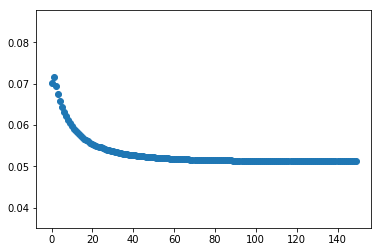

In [88]:
from matplotlib.pyplot import scatter
scatter(alphas, mses);

# Resources and stretch goals

Resources:
- https://www.quora.com/What-is-regularization-in-machine-learning
- https://blogs.sas.com/content/subconsciousmusings/2017/07/06/how-to-use-regularization-to-prevent-model-overfitting/
- https://machinelearningmastery.com/introduction-to-regularization-to-reduce-overfitting-and-improve-generalization-error/
- https://towardsdatascience.com/ridge-and-lasso-regression-a-complete-guide-with-python-scikit-learn-e20e34bcbf0b
- https://stats.stackexchange.com/questions/111017/question-about-standardizing-in-ridge-regression#111022

Stretch goals:
- Revisit past data you've fit OLS models to, and see if there's an `alpha` such that ridge regression results in a model with lower MSE on a train/test split
- Yes, Ridge can be applied to classification! Check out [sklearn.linear_model.RidgeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html#sklearn.linear_model.RidgeClassifier), and try it on a problem you previous approached with a different classifier (note - scikit LogisticRegression also automatically penalizes based on the $L^2$ norm, so the difference won't be as dramatic)
- Implement your own function to calculate the full cost that ridge regression is optimizing (the sum of squared residuals + `alpha` times the sum of squared coefficients) - this alone won't fit a model, but you can use it to verify cost of trained models and that the coefficients from the equivalent OLS (without regularization) may have a higher cost